In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import os
import math
import random
import shutil
import cv2
import imghdr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy
from scipy import ndimage
from keras.utils import load_img, img_to_array
from prettytable import PrettyTable

In [2]:
gpus = tf.config.list_physical_devices('GPU')
#gpus = tf.config.list_physical_devices()
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#minimise gpu limit consumption growth
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
BASE_DIR = 'data/'
names = ["carton_cardboards", "glass_bottles","others", "paper_printed","plastic_bottles","plastic_ordinary"]
classes = ["carton_cardboards", "glass_bottles","others", "paper_printed","plastic_bottles","plastic_ordinary"]
num_classes = len(classes)

# tf.random.set_seed(1)
img_exts = ['jpeg','jpg','bmp','png']

In [30]:
#check and clean images
for image_class in os.listdir(BASE_DIR): 
    for image in os.listdir(os.path.join(BASE_DIR, image_class)):
        image_path = os.path.join(BASE_DIR, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [6]:
#img = cv2.imread(os.path.join(data_dir,'sad','8iAb9k4aT.jpg'))
#img.shape
#plt.imshow(img)

In [31]:
#reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [32]:
# Re-arrange the image files
orig_folders = ["carton_cardboards/", "glass_bottles/","others/", "paper_printed/","plastic_bottles/","plastic_ordinary/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
#     n_train = int((number_of_images * 0.8) + 0.5)
#     n_valid = int((number_of_images*0.1) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

720 432 180 108
720 432 180 108
377 226 94 57
720 432 180 108
720 432 180 108
719 431 180 108


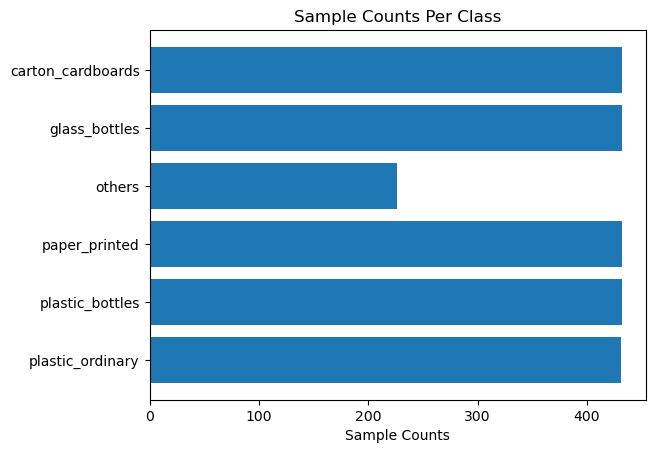

In [5]:
classes= []
sample_counts= []

for f in os.listdir(BASE_DIR+'train'):
    train_class_path= os.path.join(BASE_DIR+'train', f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(classes))

ax.barh(y_pos, sample_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Counts')
ax.set_title('Sample Counts Per Class')

plt.show()

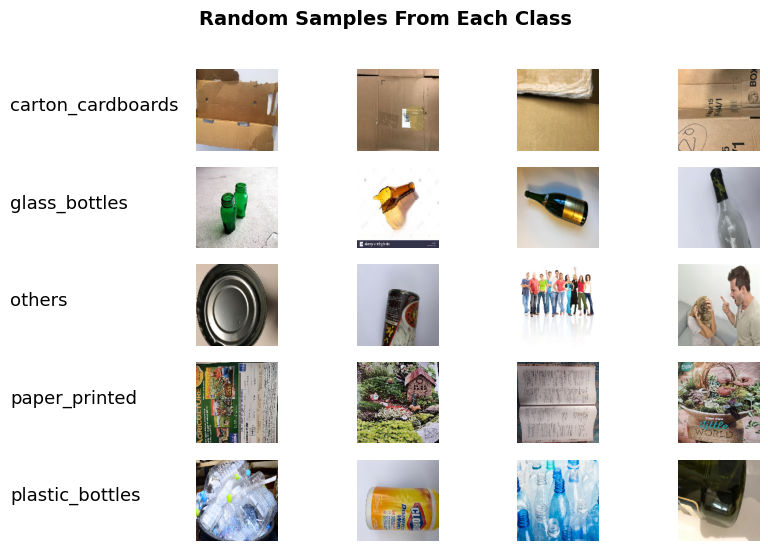

In [6]:
fig= plt.figure(figsize= (10, 15))
fig.suptitle('Random Samples From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

columns = 5
rows = 12
for i in range(5):
    sample_class= os.path.join(BASE_DIR+'train',classes[i])
    for j in range(1,6):
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        if j==1:
            plt.text(0.0, 0.5,str(classes[i]).replace(' ','\n'), fontsize=13, wrap=True)
            continue
        random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        #from keras.preprocessing.image
        img = tf.keras.utils.load_img(random_image, target_size=(150, 150))
        img= tf.keras.utils.img_to_array(img)
        img/=255.
        plt.imshow(img)

plt.show()

In [35]:
# Generate batches of tensor image data with
# optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]

mBatch_size = 16
image_size = 224

# train_gen = keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest',
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1)

# train_gen = keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     horizontal_flip=True,
#     width_shift_range=0.2, 
#     height_shift_range=0.2,
#     shear_range=0.2, 
#     zoom_range=0.2)

# train_gen = keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True)



train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'data/train',
    target_size=(image_size, image_size),
    #use sparce if using SparseCategoricalCrossentropy
    #class_mode='sparse',
    class_mode='categorical',
    batch_size=mBatch_size,
    shuffle=True,
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'data/val',
#     keep_aspect_ratio=True,
    target_size=(image_size, image_size),
    #class_mode='sparse',
    class_mode='categorical',
    batch_size=mBatch_size,
    shuffle=False,
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'data/test',
    target_size=(image_size, image_size),
    #class_mode='sparse',
    class_mode='categorical',
    batch_size=mBatch_size,
    shuffle=False,
    classes=names
)

stepsPerEpoch = np.ceil(train_batches.samples/mBatch_size)
validationSteps = np.ceil(val_batches.samples/mBatch_size)

Found 2385 images belonging to 6 classes.
Found 994 images belonging to 6 classes.
Found 597 images belonging to 6 classes.


D:\anaconda3\envs\onnx\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


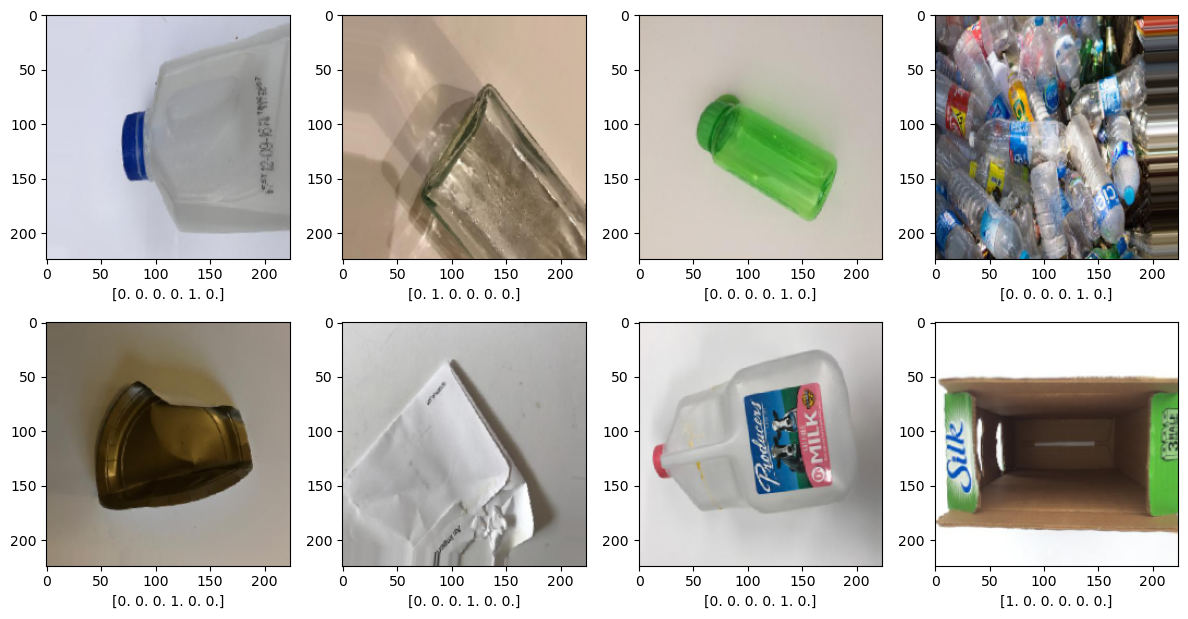

In [12]:
# show random train batch
plt.figure(figsize=(12, 12))
for i in range(0, 8):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in train_batches:
        image = X_batch[0]
        plt.imshow(image)
        plt.xlabel(Y_batch[0])
        break
plt.tight_layout()
plt.show()

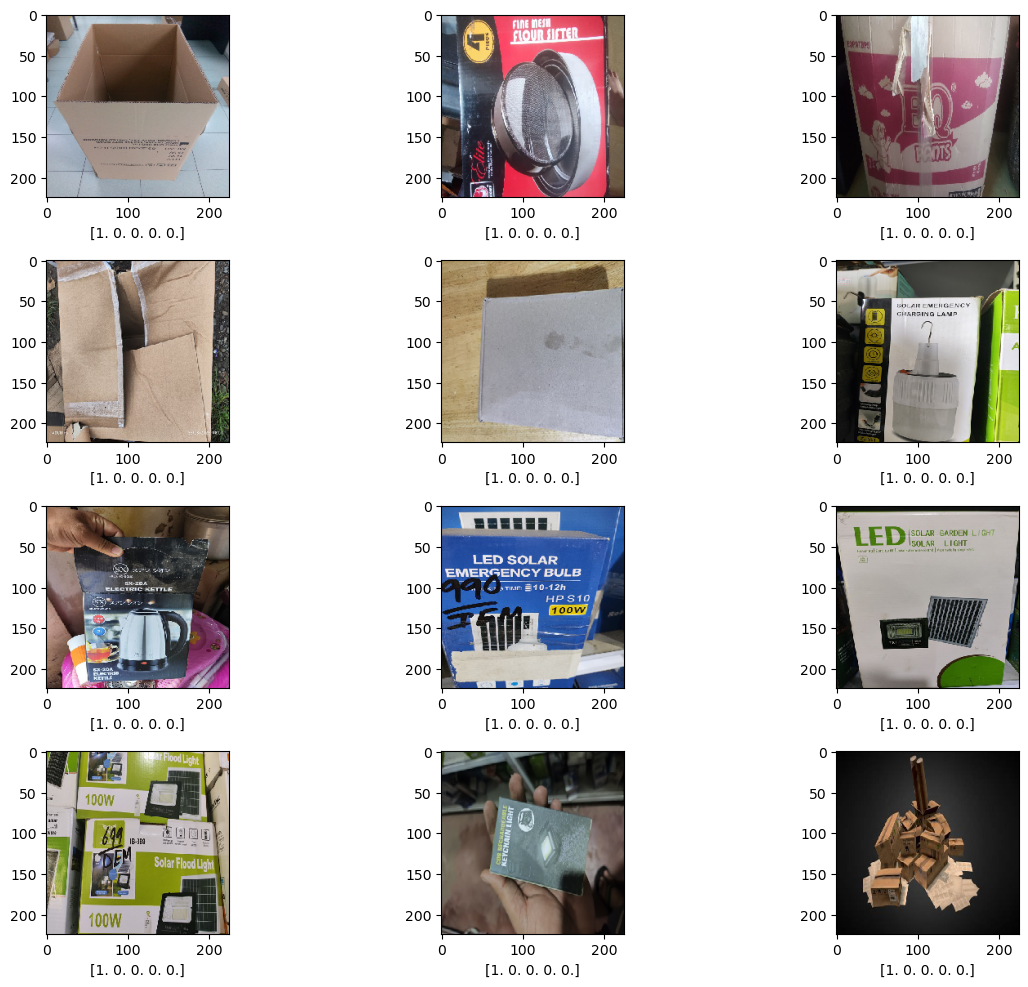

In [31]:
# show random validation batch
plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in val_batches:
        image = X_batch[0]
        plt.imshow(image)
        plt.xlabel(Y_batch[0])
        break
plt.tight_layout()
plt.show()

I will now construct a set of class weights to be provided during training in order to account for the class imbalance I've noted earlier. The result will be a value will be centered around 1, which represents the weight that will be applied to the loss value for the corresponding class. A higher weight value will essentially tell the optimizer to treat these class as more important when adjusting trainable parameters.

Using a normalized inverse frequency will produce higher weights for under-represented classes, which will avoid situations in which our CNN gives preference to certain classes just because there are more records from that class. This set of class weights are provided to the model's fit_generator method. 

from https://github.com/Reedr1208/seedling_classification/blob/master/Seedling_Classification.ipynb

In [13]:
#get class indices and labels. calculate class weight
label_map = {}
for k, v in train_batches.class_indices.items():
    label_map[v]=k

class_counts= pd.Series(train_batches.classes).value_counts()
class_weight= {}

for i, c in class_counts.items():
    class_weight[i]= 1.0/c
    
norm_factor= np.mean(list(class_weight.values()))

for k in class_counts.keys():
    class_weight[k]= class_weight[k]/norm_factor

t = PrettyTable(['class_index', 'class_label', 'class_weight'])
for i in sorted(class_weight.keys()):
    t.add_row([i, label_map[i], '{:.2f}'.format(class_weight[i])])
print(t)

+-------------+-------------------+--------------+
| class_index |    class_label    | class_weight |
+-------------+-------------------+--------------+
|      0      | carton_cardboards |     0.87     |
|      1      |   glass_bottles   |     0.87     |
|      2      |       others      |     1.66     |
|      3      |   paper_printed   |     0.87     |
|      4      |  plastic_bottles  |     0.87     |
|      5      |  plastic_ordinary |     0.87     |
+-------------+-------------------+--------------+


In [36]:
# build model 1 
model = keras.models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_size, image_size,3)))
model.add(layers.Conv2D(32,(3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(6,activation='softmax'))

# build model 5
# without using image generators yield 
# 62% validation accuracy
# 56% test accuracy
# note: highest so far nov 1 2023
# note: hyper params learning_rate=0.0001
# model = keras.models.Sequential()
# model.add(layers.Conv2D(8, kernel_size=(3,3), padding='same', input_shape=(image_size,image_size,3), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Conv2D(16, kernel_size=(3,3), padding='same',activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))
# model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same',activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))

# model.add(layers.Flatten())

# model.add(layers.Dense(64,activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(6,activation='softmax'))

# build model 6
# without using image generators yield 
# 
# 
# note: validation and test loss graph shows close with each other
# note: hyper params learning_rate=0.0001
# model = keras.models.Sequential()
# model.add(layers.Conv2D(8, kernel_size=(3,3), padding='same', input_shape=(image_size,image_size,3), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))

# model.add(layers.Conv2D(16, kernel_size=(3,3), padding='same',activation='relu'))
# model.add(layers.Conv2D(16, kernel_size=(3,3), padding='same',activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))

# model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same',activation='relu'))
# model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same',activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(pool_size=(2,2)))

# model.add(layers.Flatten())

# model.add(layers.Dense(64,activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64,activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(6,activation='softmax'))

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_29 (Conv2D)          (None, 220, 220, 32)      4640      
                                                                 
 batch_normalization_11 (Bat  (None, 220, 220, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 batch_normalization_12 (Bat  (None, 108, 108, 64)    

In [37]:
from keras.optimizers import RMSprop
# loss and optimizer
loss = keras.losses.CategoricalCrossentropy()
# optim = keras.optimizers.Adam(learning_rate=0.001,amsgrad=True)
optim = keras.optimizers.Adam(learning_rate=0.0001)
# optim = RMSprop(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [38]:
# training
epochs = 40


# best_cb = keras.callbacks.ModelCheckpoint(
#     'best_model_oct_28_2023.h5',
#     monitor="val_accuracy",
#     verbose=1,
#     save_best_only=True)

# history = model.fit(train_batches,
#                     validation_data=val_batches,
#                     class_weight= class_weight,
#                     callbacks=[best_cb],
#                     epochs=epochs,
#                     use_multiprocessing=True,
#                     verbose=1)

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, 
    verbose = 1
)

# history = model.fit(train_batches,
#                     validation_data=val_batches,
# #                     class_weight= class_weight,
#                     callbacks=[early_stopping,best_cb],
#                     epochs=epochs,
# #                     steps_per_epoch=stepsPerEpoch,
# #                     validation_steps=validationSteps,
#                     verbose=1)

history = model.fit(train_batches,
                    validation_data=val_batches,
                    callbacks=[early_stopping],
#                     steps_per_epoch=3,
                    class_weight= class_weight,
#                     steps_per_epoch=stepsPerEpoch,
#                     validation_steps=validationSteps,
                    epochs=epochs,
                    verbose=1)

Epoch 1/40
150/150 [==============================] - 61s 387ms/step - loss: 1.7338 - accuracy: 0.4738 - val_loss: 5.5285 - val_accuracy: 0.1952
Epoch 2/40
150/150 [==============================] - 59s 396ms/step - loss: 1.0214 - accuracy: 0.6423 - val_loss: 3.8163 - val_accuracy: 0.2988
Epoch 3/40
150/150 [==============================] - 60s 397ms/step - loss: 0.8564 - accuracy: 0.6952 - val_loss: 4.8291 - val_accuracy: 0.3239
Epoch 4/40
150/150 [==============================] - 59s 393ms/step - loss: 0.6615 - accuracy: 0.7572 - val_loss: 3.0704 - val_accuracy: 0.3773
Epoch 5/40
150/150 [==============================] - 59s 396ms/step - loss: 0.4760 - accuracy: 0.8285 - val_loss: 2.4782 - val_accuracy: 0.4185
Epoch 6/40
150/150 [==============================] - 60s 400ms/step - loss: 0.4118 - accuracy: 0.8486 - val_loss: 2.4686 - val_accuracy: 0.4135
Epoch 7/40
150/150 [==============================] - 62s 414ms/step - loss: 0.3300 - accuracy: 0.8759 - val_loss: 2.5689 - val_ac

In [39]:
score_val = model.evaluate(val_batches)
print(f'Validation batch accuracy: {score_val[1] * 100} %')

63/63 [==============================] - 4s 54ms/step - loss: 3.2448 - accuracy: 0.3753
Validation batch accuracy: 37.525150179862976 %


In [40]:
# evaluate on test data
sore_test = model.evaluate(test_batches, verbose=2)
print(f'Test batch accuracy: {sore_test[1] * 100} %')

38/38 - 8s - loss: 3.7068 - accuracy: 0.3400 - 8s/epoch - 212ms/step
Test batch accuracy: 34.003350138664246 %


In [36]:
# model.save("best_model_nov1_2023_62.h5")

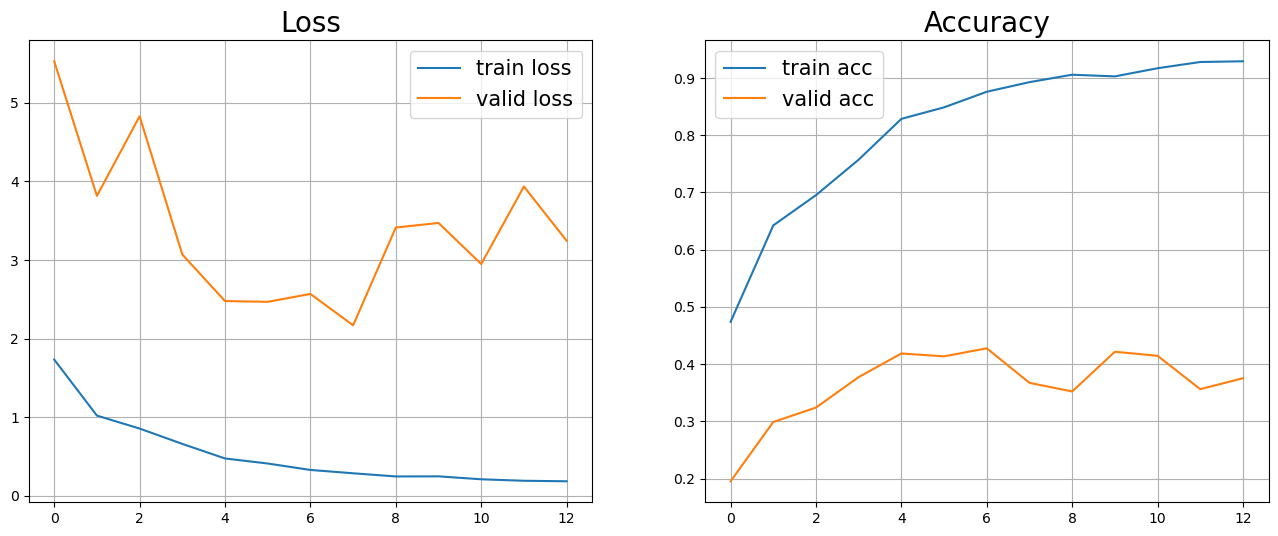

In [41]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.title('Loss', fontsize=20)
plt.legend(fontsize=15)


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.title('Accuracy', fontsize=20)
plt.legend(fontsize=15);

In [58]:
# make some predictions
predictions = model.predict(test_batches)
print(predictions)
#predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)
predicted_class_indices = np.argmax(predictions, axis=1)

100/100 [==============================] - 2s 20ms/step
[[8.2083736e-03 5.4998291e-01 4.6304572e-02 3.5569805e-01 2.4295980e-02
  1.5510081e-02]
 [8.8250287e-02 9.6218504e-02 4.5058203e-01 7.1578540e-02 1.9151130e-01
  1.0185937e-01]
 [5.3726036e-02 1.0777341e-01 7.0940119e-01 1.0617077e-01 1.1130090e-02
  1.1798573e-02]
 ...
 [4.1724987e-02 1.8515946e-02 1.2536273e-02 2.2243211e-02 1.6701213e-01
  7.3796749e-01]
 [1.0127468e-03 9.7907269e-03 8.3502789e-05 2.4786925e-01 5.7826692e-01
  1.6297683e-01]
 [3.2353532e-02 3.5865229e-01 1.7472586e-01 3.5160758e-02 3.1022045e-01
  8.8887088e-02]]


In [59]:
labels = (test_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_batches.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,carton_cardboards\IMG_20230826_081757.jpg,glass_bottles
1,carton_cardboards\IMG_20230826_081902.jpg,others
2,carton_cardboards\IMG_20230826_081908.jpg,others
3,carton_cardboards\IMG_20230826_081913.jpg,plastic_ordinary
4,carton_cardboards\IMG_20230826_081918.jpg,paper_printed
...,...,...
392,plastic_ordinary\regal-rosewood4-b.jpg,glass_bottles
393,plastic_ordinary\regal-teakwood2-b.jpg,glass_bottles
394,plastic_ordinary\s-l1000 (1).jpg,plastic_ordinary
395,plastic_ordinary\s-l1000.jpg,plastic_bottles


In [60]:
import matplotlib.image as mpimg

(792, 456, 3)

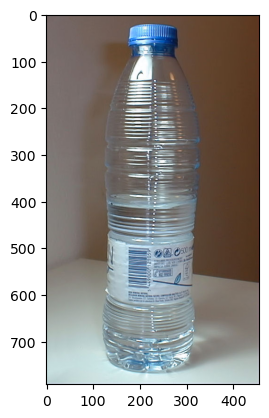

In [61]:
my_image = mpimg.imread('Botella_de_plástico_-_PET.jpg')
plt.imshow(my_image)
my_image.shape

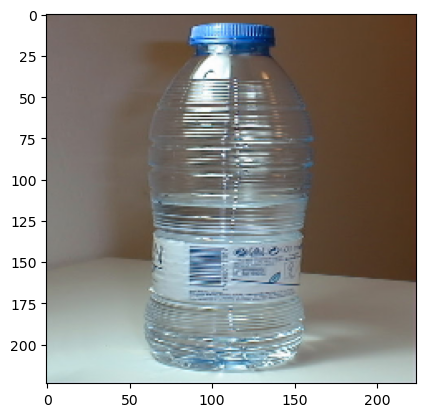

In [62]:
# my_image = tf.io.read_file('Botella_de_plástico_-_PET.jpg')
my_image = tf.io.read_file('Botella_de_plástico_-_PET.jpg')
my_image = tf.image.decode_image(my_image)
my_image = tf.image.resize(my_image,size=[224,224])
# my_image = tf.image.resize_with_pad(my_image,256,256)
my_image = my_image / 255
my_image
plt.imshow(my_image)

In [63]:
my_predict = model.predict(tf.expand_dims(my_image,axis=0))
#np.argmax(my_predict)
predicted_name = names[np.argmax(my_predict)]
predicted_name

1/1 [==============================] - 0s 215ms/step


'others'

In [45]:
# convert keras model to tflite 
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

model =tf.keras.models.load_model("best_model_oct_24_2023.h5")

#Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#Implement optimization strategy for smaller model sizes
#converter.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
tflite_model = converter.convert()
open("best_model_oct_24_2023.tflite", "wb").write(tflite_model)
convert_bytes(get_file_size("best_model_oct_24_2023.tflite"), "KB")

INFO:tensorflow:Assets written to: C:\Users\MIXYES~1\AppData\Local\Temp\tmpm6uwe3rt\assets


INFO:tensorflow:Assets written to: C:\Users\MIXYES~1\AppData\Local\Temp\tmpm6uwe3rt\assets


File size: 21751.004 Kilobytes


In [46]:
interpreter = tf.lite.Interpreter(model_path = "best_model_oct_24_2023.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


In [47]:
from time import time

tflite_model_path = "best_model_oct_24_2023.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on input data.
input_shape = input_details[0]['shape']
print(input_shape)

# Load image
input_data = my_image
input_data = np.expand_dims(input_data, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)

time_before=time()
interpreter.invoke()
time_after=time()
total_tflite_time = time_after - time_before
print("Total prediction time for tflite model is: ", total_tflite_time)

output_data_tflite = interpreter.get_tensor(output_details[0]['index'])
print("The tflite prediction for this image is: ", output_data_tflite, 'or',names[np.argmax(output_data_tflite)])
print(output_data_tflite[0][0])
print(output_data_tflite[0][1])
print(output_data_tflite[0][2])
print(output_data_tflite[0][3])
print(output_data_tflite[0][4])
print(output_data_tflite[0][5])
print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(names[np.argmax(output_data_tflite)], 100 * np.max(output_data_tflite)))

[  1 224 224   3]
Total prediction time for tflite model is:  0.01914525032043457
The tflite prediction for this image is:  [[0.11134974 0.13315438 0.18628637 0.33525288 0.23395663]] or plastic_bottles
0.11134974
0.13315438
0.18628637
0.33525288
0.23395663
This image most likely belongs to plastic_bottles with a 33.53 percent confidence.
